In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
import youtube_dl
%matplotlib inline


from ipynb.fs.full.COCO_Keypoints import PoseTrack_Keypoint_Pairs, PoseTrack_COCO_Keypoint_Ordering, COLOR_DICT

In [2]:
DATA_PATH = '../dataset/'
FILE = DATA_PATH + 'wimbledon_2019_womens_final_halep_williams__fduc5bZx3ss.pose.json'
VIDEO_URL = 'https://www.youtube.com/watch?v=' + FILE.split('__')[1].split('.')[0]
W = 1920
H = 1080
f = json.load(open(FILE, 'r'))

# 58 min video --> 3366 seconds, frame rate: 25 fps, total frames = 33660. W=1920 H=1080

# File structure
# 3 lists: person, racket, ball  (each one has a different length)
# Person
# 2 element list: timestamp, person detections
# Person detection: score, xywh, pose (17 keypoints)

In [120]:
def plot_frame_from_youtube_video(frame_no):
    ydl_opts = {'quiet': True}
    ydl = youtube_dl.YoutubeDL(ydl_opts)
    info_dict = ydl.extract_info(VIDEO_URL, download=False)
    formats = info_dict.get('formats',None)
    for f in formats:
        if f['format_id'] == '399':
            url = f.get('url',None)
            cap = cv2.VideoCapture(url)
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
            ret, frame = cap.read()
            if ret:
                plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                return frame
                #plt.show()
            else:
                print('No frame obtained. Rerun code.')
    return None

In [121]:
def plot_pose(data):
    keypoints = data['pose'][0]
    x,y,w,h = data['xywh']
    
    fig, ax = plt.subplots()
    for i, p in enumerate(keypoints):
        # Avoid plotting ears and nose
        k = PoseTrack_COCO_Keypoint_Ordering[i]
        if 'ear' in k or 'nose' in k: continue
        ax.scatter(p[0]-x,p[1]-y,c='b',marker='.')
        ax.annotate(k, (p[0]-x, p[1]-y))
            
    for joint_pair in PoseTrack_Keypoint_Pairs:
        
        ind_1 = PoseTrack_COCO_Keypoint_Ordering.index(joint_pair[0])
        ind_2 = PoseTrack_COCO_Keypoint_Ordering.index(joint_pair[1])
        
        color = COLOR_DICT[joint_pair[2]]
        x1, y1, _ = keypoints[ind_1]
        x2, y2, _ = keypoints[ind_2]
                
        plt.plot([x1-x, x2-x], [y1-y, y2-y], [tuple(ti/255 for ti in color)], linewidth=2)
        
    plt.xlim(0,w)
    plt.ylim(h,0)
    plt.gca().set_aspect('equal')
    plt.show()

In [130]:
def plot_poses_in_frame(poses_p1, poses_p2, frame_no):
    
    plt.figure(figsize=(8,8))
    
    # Plot main image
    plt.subplot(2, 1, 2)
    
    frame = plot_frame_from_youtube_video(frame_no)
    if frame is None:
        plt.close()
        return
        
    # Plot player 1
    
    plt.subplot(2, 2, 1)
    keypoints = poses_p1['pose'][0]
    x,y,w,h = list(map(int, poses_p1['xywh']))
    plt.imshow(cv2.cvtColor(frame[y:y+h,x:x+w,:], cv2.COLOR_BGR2RGB),alpha=0.6)
    for joint_pair in PoseTrack_Keypoint_Pairs:
        
        ind_1 = PoseTrack_COCO_Keypoint_Ordering.index(joint_pair[0])
        ind_2 = PoseTrack_COCO_Keypoint_Ordering.index(joint_pair[1])
        
        color = COLOR_DICT[joint_pair[2]]
        x1, y1, _ = keypoints[ind_1]
        x2, y2, _ = keypoints[ind_2]
                
        plt.plot([x1-x, x2-x], [y1-y, y2-y], [tuple(ti/255 for ti in color)], linewidth=2)
    
    
    # Plot player 2
    
    plt.subplot(2, 2, 2)
    keypoints = poses_p2['pose'][0]
    x,y,w,h = list(map(int, poses_p2['xywh']))
    plt.imshow(cv2.cvtColor(frame[y:y+h,x:x+w,:], cv2.COLOR_BGR2RGB),alpha=0.6)
    for joint_pair in PoseTrack_Keypoint_Pairs:
        
        ind_1 = PoseTrack_COCO_Keypoint_Ordering.index(joint_pair[0])
        ind_2 = PoseTrack_COCO_Keypoint_Ordering.index(joint_pair[1])
        
        color = COLOR_DICT[joint_pair[2]]
        x1, y1, _ = keypoints[ind_1]
        x2, y2, _ = keypoints[ind_2]
                
        plt.plot([x1-x, x2-x], [y1-y, y2-y], [tuple(ti/255 for ti in color)], linewidth=2)
    
    plt.tight_layout()
    plt.show()

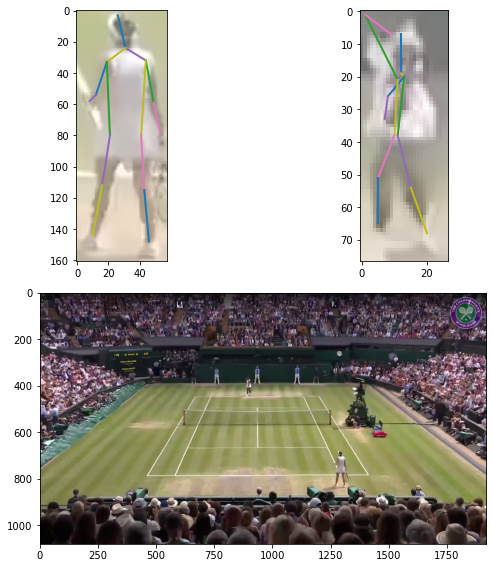

In [131]:
plot_poses_in_frame(f['person'][0][1][0], 
          f['person'][0][1][1],
          frame_no=f['person'][0][0])